# 3 state discrimination

## Loading

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import custom_object_scope
import keras.backend as K
from keras.constraints import Constraint
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns


In [2]:
state0=np.load('/pscratch/sd/n/nrvora/Data/Quantum/Data/ML/072924/state0.npy')
state1=np.load('/pscratch/sd/n/nrvora/Data/Quantum/Data/ML/072924/state1.npy')
state2=np.load('/pscratch/sd/n/nrvora/Data/Quantum/Data/ML/072924/state2.npy')
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
output2=np.array((2,)*state2.shape[0])



## LOC

0.15615031207183552
72017.16523639241


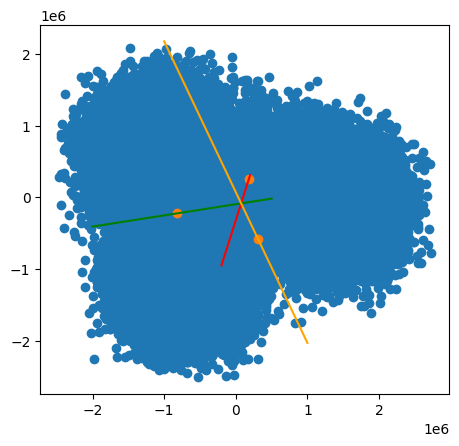

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# # Generate synthetic data
# np.random.seed(42)
# state0 = np.random.normal(loc=[5, -1], scale=[1, 1], size=(10000, 2))
# state1 = np.random.normal(loc=[6, 6], scale=[1, 1], size=(10000, 2))
# state2 = np.random.normal(loc=[12, 1], scale=[1, 1], size=(10000, 2))
data = np.vstack([state0, state1, state2])


plt.scatter(data[:,0],data[:,1])
center = np.array([state0.mean(axis=0), state1.mean(axis=0), state2.mean(axis=0)])
slop=np.array([(center[1][1]-center[0][1])/(center[1][0]-center[0][0]), (center[2][1]-center[1][1])/(center[2][0]-center[1][0]), (center[0][1]-center[2][1])/(center[0][0]-center[2][0])])
intercept = np.array([center[0][1]-(slop[0]*center[0][0]), center[1][1]-(slop[1]*center[1][0]), center[2][1]-(slop[2]*center[2][0])])
dp = np.array([[(center[1][0]+center[0][0])/2,(center[1][1]+center[0][1])/2], [(center[2][0]+center[1][0])/2,(center[2][1]+center[1][1])/2], [(center[0][0]+center[2][0])/2,(center[0][1]+center[2][1])/2]])
# plt.plot([center[0][0],center[1][0]],[center[0][1],center[1][1]],color='red')
plt.scatter(dp[:,0],dp[:,1])
#orthogonal
orthSlop=-1/slop
orthIntercept=np.array([dp[0][1]-(orthSlop[0]*dp[0][0]), dp[1][1]-(orthSlop[1]*dp[1][0]), dp[2][1]-(orthSlop[2]*dp[2][0])])
x=np.array([[-.2e6,.2e6],[-2e6,.5e6],[-1e6,1e6]])
y=np.array([[(x[0][0]*orthSlop[0])+orthIntercept[0],(x[0][1]*orthSlop[0])+orthIntercept[0]], [(x[1][0]*orthSlop[1])+orthIntercept[1],(x[1][1]*orthSlop[1])+orthIntercept[1]], [(x[2][0]*orthSlop[2])+orthIntercept[2],(x[2][1]*orthSlop[2])+orthIntercept[2]]])

plt.plot(x[0],y[0],color='red')
plt.plot(x[1],y[1],color='green')
plt.plot(x[2],y[2],color='orange')

plt.gca().set_aspect('equal', adjustable='box')
print(orthSlop[1])
print(orthIntercept[2])

In [33]:
## Inference
count0=0
for i in state0:
    vector_i=[i[0]-center[0],i[1]-center[1]]
    proj = np.dot(vector,vector_i)
    if proj>0:
        count0+=1
print(count0/state0.shape[0])
count1=0
for i in state1:
    vector_i=[i[0]-center[0],i[1]-center[1]]
    proj = np.dot(vector,vector_i)
    if proj<0:
        count1+=1
print(count1/state1.shape[0])


NameError: name 'vector' is not defined

## Scaling

In [3]:
x=np.concatenate((state0,state1,state2),axis=0)
print(x.shape)
y=np.hstack((output0,output1,output2))
print(y.shape)


# ##########EMU
# x=np.concatenate((state0,state1),axis=0)
# print(x.shape)
# y=np.hstack((output0,output1))
# print(y.shape)


encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(y.reshape(-1, 1))
y1 = one_hot_encoded.toarray()
print(y1.shape)

# ######EMU
# ex=np.zeros((y1.shape[0],1))
# y_emu=np.concatenate((y1,ex),axis=1)
# y_emu


(36000, 2)
(36000,)
(36000, 3)


[-3.04602607e+08 -3.36472559e+09]


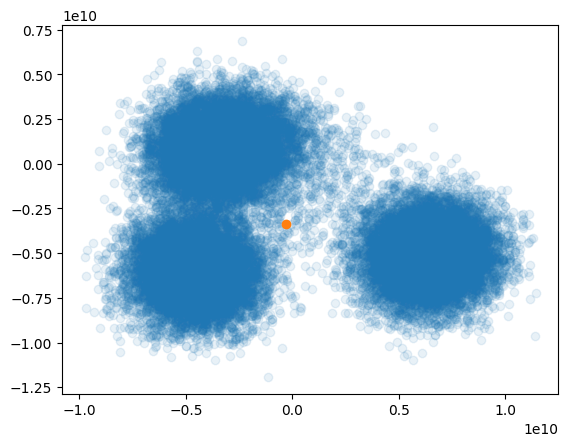

In [4]:
mean=np.mean(x,axis=0)
plt.scatter(x[:,0],x[:,1],alpha=0.1)
plt.scatter(mean[0],mean[1],alpha=1)
print(mean)

11107812293.0 -10051839807.0
3487562711.0 -15311964077.0
[-6.09205214e+08 -6.72945117e+09]


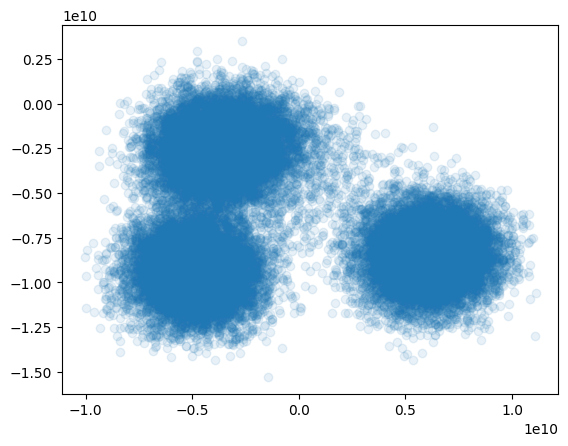

In [5]:
x[:,0]+= int(mean[0])
x[:,1]+= int(mean[1])
print(x[:,0].max(),x[:,0].min())
print(x[:,1].max(),x[:,1].min())
plt.scatter(x[:,0],x[:,1],alpha=0.1)
mean=np.mean(x,axis=0)
print(mean)

0.8232798856915906 0.20745295844972134
0.6015014338190667 0.0543631935142912


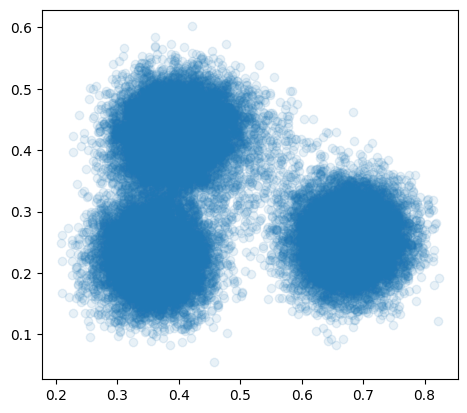

In [6]:
x[:,0]=(x[:,0]+(2**34)-1)/(2**35)
x[:,1]=(x[:,1]+(2**34)-1)/(2**35)
print(x[:,0].max(),x[:,0].min())
print(x[:,1].max(),x[:,1].min())
plt.gca().set_aspect('equal')
plt.scatter(x[:,0],x[:,1],alpha=0.1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y1, test_size=0.40, random_state=45)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(21600, 2)
(14400, 2)
(21600, 3)


## Cleaning

In [ ]:

def md(cluster_mean, cluster_covariance, point):
    # Calculate the difference between the point and the mean of the cluster
    diff = point - cluster_mean
    
    # Calculate the inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(cluster_covariance)
    
    # Calculate the Mahalanobis distance
    mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    
    return mahalanobis_dist


In [ ]:
µ0,µ1,µ2=np.mean(x_train[(y_train==[1,0,0]).all(axis=1),:], axis=0),np.mean(x_train[(y_train==[0,1,0]).all(axis=1),:], axis=0),np.mean(x_train[(y_train==[0,0,1]).all(axis=1),:], axis=0)
cov0,cov1,cov2=np.cov(x_train[(y_train==[1,0,0]).all(axis=1)],rowvar=False),np.cov(x_train[(y_train==[0,1,0]).all(axis=1)],rowvar=False),np.cov(x_train[(y_train==[0,0,1]).all(axis=1)],rowvar=False)

In [ ]:
x_train_pro,y_train_pro=[],[]
for i in range(x_train.shape[0]):
    if (y_train[i]==[1,0,0]).all():
        dist_og,dist1,dist2=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist2,dist1,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
    elif (y_train[i]==[0,1,0]).all():
        dist0,dist_og,dist2=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist2,dist0,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
    else:   
        dist0,dist1,dist_og=md(µ0,cov0,x_train[i]),md(µ1,cov1,x_train[i]),md(µ2,cov2,x_train[i])
        if min(dist1,dist0,dist_og)== dist_og:
            x_train_pro.append(x_train[i])
            y_train_pro.append(y_train[i])
x_train_pro=np.array(x_train_pro)
y_train_pro=np.array(y_train_pro)

In [ ]:
plt.scatter(x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),0],x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),1], alpha=0.1, label = '|0>')
plt.scatter(x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),0],x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),1], alpha=0.1, label = '|1>')
plt.scatter(x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),0],x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),1], alpha=0.1, label = '|2>')
plt.title('Q3 Train')
# plt.legend()
plt.show()


In [ ]:
plt.scatter(x_test[(y_test==[1,0,0]).all(axis=1),0],x_test[(y_test==[1,0,0]).all(axis=1),1], alpha=0.1, label = '|0>')
plt.scatter(x_test[(y_test==[0,1,0]).all(axis=1),0],x_test[(y_test==[0,1,0]).all(axis=1),1], alpha=0.1, label = '|1>')
plt.scatter(x_test[(y_test==[0,0,1]).all(axis=1),0],x_test[(y_test==[0,0,1]).all(axis=1),1], alpha=0.1, label = '|2>')
plt.title('Q3 Test')
# plt.legend()
plt.show()

## Lines

In [ ]:
state0=x_train_pro[(y_train_pro==[1,0,0]).all(axis=1),:]
state1=x_train_pro[(y_train_pro==[0,1,0]).all(axis=1),:]
state2=x_train_pro[(y_train_pro==[0,0,1]).all(axis=1),:]

plt.scatter(state0[:,0],state0[:,1],alpha=0.1)
plt.scatter(state1[:,0],state1[:,1],alpha=0.1)
plt.scatter(state2[:,0],state2[:,1],alpha=0.1)


m = -1.145  # Example slope
b = 1.08  # Example intercept
x = np.linspace(0.45, .6, 100)  # Generate 100 points between -10 and 10
y1 = m * x + b
n1 = np.array([-1.145, -1])
plt.plot(x, y1, color='red')
plt.title('Line Plot')
x_pointr = 0.53
y_pointr = m * x_pointr + b
plt.quiver(x_pointr, y_pointr, n1[0], n1[1], color='red', scale=10)

m = 38.80  # Example slope
b = -18.99  # Example intercept
x = np.linspace(0.502, .507, 100)  # Generate 100 points between -10 and 10
y2 = m * x + b
n2 = np.array([38.80, -1])
plt.plot(x, y2, color='blue')
plt.title('Line Plot')
x_pointb = .5045
y_pointb = m * x_pointb + b
plt.quiver(x_pointb, y_pointb, n2[0], n2[1], color='blue', scale=200)

m = 0.11  # Example slope
b = 0.47 # Example intercept
x = np.linspace(.25, .55, 100)  # Generate 100 points between -10 and 10
y3 = m * x + b
n3 = np.array([-0.11, 1])
plt.plot(x, y3, color='green')
plt.title('Line Plot')
x_pointg = .4
y_pointg = m * x_pointg + b
plt.quiver(x_pointg, y_pointg, n3[0], n3[1], color='green', scale=10)


In [ ]:
pred0,state0=0,0
pred1,state1=0,0
pred2,state2=0,0
for k,i in enumerate(x_train_pro):
    if (y_train_pro[k,]==[1,0,0]).all():
        if np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) > 0 and np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) < 0:
            pred0+=1
        state0+=1
    elif (y_train_pro[k,]==[0,1,0]).all():
        if np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) > 0 and np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) < 0:
            pred1+=1
        state1+=1
    elif (y_train_pro[k,]==[0,0,1]).all():
        if np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) > 0 and np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) < 0:
            pred2+=1
        state2+=1
print(pred0/state0)
print(pred1/state1)
print(pred2/state2)


In [ ]:
state0=x_test[(y_test==[1,0,0]).all(axis=1),:]
state1=x_test[(y_test==[0,1,0]).all(axis=1),:]
state2=x_test[(y_test==[0,0,1]).all(axis=1),:]

plt.scatter(state0[:,0],state0[:,1],alpha=0.1)
plt.scatter(state1[:,0],state1[:,1],alpha=0.1)
plt.scatter(state2[:,0],state2[:,1],alpha=0.1)

m = -1.145  # Example slope
b = 1.08  # Example intercept
x = np.linspace(0.45, .6, 100)  # Generate 100 points between -10 and 10
y1 = m * x + b
n1 = np.array([-1.145, -1])
plt.plot(x, y1, color='red')
plt.title('Line Plot')
x_pointr = 0.53
y_pointr = m * x_pointr + b
plt.quiver(x_pointr, y_pointr, n1[0], n1[1], color='red', scale=10)

m = 38.80  # Example slope
b = -18.99  # Example intercept
x = np.linspace(0.502, .507, 100)  # Generate 100 points between -10 and 10
y2 = m * x + b
n2 = np.array([38.80, -1])
plt.plot(x, y2, color='blue')
plt.title('Line Plot')
x_pointb = .5045
y_pointb = m * x_pointb + b
plt.quiver(x_pointb, y_pointb, n2[0], n2[1], color='blue', scale=200)

m = 0.11  # Example slope
b = 0.47 # Example intercept
x = np.linspace(.25, .55, 100)  # Generate 100 points between -10 and 10
y3 = m * x + b
n3 = np.array([-0.11, 1])
plt.plot(x, y3, color='green')
plt.title('Line Plot')
x_pointg = .4
y_pointg = m * x_pointg + b
plt.quiver(x_pointg, y_pointg, n3[0], n3[1], color='green', scale=10)

In [ ]:
pred0,state0=0,0
pred1,state1=0,0
pred2,state2=0,0
for k,i in enumerate(x_test):
    if (y_test[k,]==[1,0,0]).all():
        if np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) > 0 and np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) < 0:
            pred0+=1
        state0+=1
    elif (y_test[k,]==[0,1,0]).all():
        if np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) > 0 and np.dot(np.array([i[0]-x_pointb, i[1]-y_pointb]).T, n2) < 0:
            pred1+=1
        state1+=1
    elif (y_test[k,]==[0,0,1]).all():
        if np.dot(np.array([i[0]-x_pointr, i[1]-y_pointr]).T, n1) > 0 and np.dot(np.array([i[0]-x_pointg, i[1]-y_pointg]).T, n3) < 0:
            pred2+=1
        state2+=1
print(pred0/state0)
print(pred1/state1)
print(pred2/state2)

## Logistic Regressor

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

In [ ]:
# Extract coefficients and intercepts
coefficients = classifier.coef_
intercepts = classifier.intercept_

# Calculate slopes and y-intercepts for decision boundaries in 2D
slopes = -coefficients[:, 0] / coefficients[:, 1]
y_intercepts = -intercepts / coefficients[:, 1]

# Print the number of decision boundaries, slopes, and intercepts
num_boundaries = len(coefficients)
print("Number of decision boundaries:", num_boundaries)
print("Slopes of each boundary:", slopes)
print("Y-intercepts of each boundary:", y_intercepts)

In [ ]:
y_pred = classifier.predict(x_test)

# Calculate the counts and ratios for each class
for class_label in range(3):  # assuming three classes: 0, 1, 2
    count = (y_test == class_label).sum()
    count1 = ((y_test == class_label) & (y_pred == class_label)).sum()
    print(f"Class {class_label}:")
    print("Total in test:", count)
    print("Correct predictions:", count1)
    print("Precision:", count1 / count if count != 0 else 0)
    print('*********')

# Compute and plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize and convert to percentage

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()


In [ ]:
x_min, x_max = x[:, 0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 20000), np.linspace(y_min, y_max, 20000))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contour(xx, yy, y_pred, colors='red', linewidths=0.6)
plt.scatter(x_test[y_test==0,0],x_test[y_test==0,1],alpha=0.1,label='|0>')
plt.scatter(x_test[y_test==1,0],x_test[y_test==1,1],alpha=0.1,label='|1>')
plt.scatter(x_test[y_test==2,0],x_test[y_test==2,1],alpha=0.1,label='|2>')
plt.title('Q6')
# plt.legend()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC
model=SVC(kernel='linear',decision_function_shape='ovr',probability=True,max_iter=100)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

## NN

In [8]:
class WeightConstraint(Constraint):
    def __init__(self, min_value=-2, max_value=2, precision=6):
        self.min_value = min_value
        self.max_value = max_value
        self.precision = precision

    def __call__(self, w):
        clipped = K.clip(w, self.min_value, self.max_value)
        return K.round(clipped * 10**self.precision) / 10**self.precision

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value, 'precision': self.precision}
# keras.saving.get_custom_objects().clear()
# @keras.saving.register_keras_serializable(package="my_package", name="custom_softmax")
# def custom_softmax(x):
#     # Applying the softmax operation
#     e_x = K.exp(x - K.max(x))
#     softmax_output = e_x / K.sum(e_x)
    
#     # You can add any other custom logic here if needed
#     return softmax_output

def arch():
    model=Sequential()
    model.add(Input(shape=(2)))
    model.add(Dense(8,activation='relu', name='HiddenLayer1',kernel_constraint=WeightConstraint()))
    # model.add(Dense(8,activation='relu', name='HiddenLayer2'))#,kernel_constraint=WeightConstraint()))
    model.add(Dense(3,activation='softmax', name='OuputLayer',kernel_constraint=WeightConstraint()))
    return model
arch().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 
 OuputLayer (Dense)          (None, 3)                 27        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-08-05 13:26:07.471348: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model=arch()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_path="../Model/qutrit_nn/tmp/{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [10]:
H=model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          validation_split=0.2,
          epochs=100,batch_size=512,
          callbacks=callbacks_list,
          verbose=1)

Epoch 1/100
 1/43 [..............................] - ETA: 17s - loss: 1.1272 - accuracy: 0.3223
Epoch 1: val_accuracy improved from -inf to 0.32625, saving model to ../Model/qutrit_nn/tmp/01-1.1065-0.3262.h5
43/43 [==============================] - 1s 7ms/step - loss: 1.1145 - accuracy: 0.3315 - val_loss: 1.1065 - val_accuracy: 0.3262
Epoch 2/100
 1/43 [..............................] - ETA: 0s - loss: 1.1050 - accuracy: 0.3594
Epoch 2: val_accuracy did not improve from 0.32625
43/43 [==============================] - 0s 3ms/step - loss: 1.0998 - accuracy: 0.2649 - val_loss: 1.0929 - val_accuracy: 0.1273
Epoch 3/100
 1/43 [..............................] - ETA: 0s - loss: 1.0936 - accuracy: 0.1152

/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy improved from 0.32625 to 0.36507, saving model to ../Model/qutrit_nn/tmp/03-1.0808-0.3651.h5
43/43 [==============================] - 0s 3ms/step - loss: 1.0872 - accuracy: 0.2440 - val_loss: 1.0808 - val_accuracy: 0.3651
Epoch 4/100
 1/43 [..............................] - ETA: 0s - loss: 1.0804 - accuracy: 0.3848
Epoch 4: val_accuracy improved from 0.36507 to 0.60278, saving model to ../Model/qutrit_nn/tmp/04-1.0679-0.6028.h5
43/43 [==============================] - 0s 4ms/step - loss: 1.0748 - accuracy: 0.4793 - val_loss: 1.0679 - val_accuracy: 0.6028
Epoch 5/100
 1/43 [..............................] - ETA: 0s - loss: 1.0677 - accuracy: 0.5898
Epoch 5: val_accuracy improved from 0.60278 to 0.75319, saving model to ../Model/qutrit_nn/tmp/05-1.0538-0.7532.h5
43/43 [==============================] - 0s 3ms/step - loss: 1.0613 - accuracy: 0.6525 - val_loss: 1.0538 - val_accuracy: 0.7532
Epoch 6/100
 1/43 [..............................] - ETA: 0s - loss: 1.0521 -

In [ ]:
np.save('xtest.npy',x_test)
np.save('ytest.npy',y_test)

In [13]:
from keras.utils import custom_object_scope
count=0
count1=0
# with custom_object_scope({'WeightConstraint': WeightConstraint}):
#     model = load_model('..//Model/qutrit_nn/Best/emu1.h5', compile=False)
y_pred=model.predict(x_test)
argmax_indices = np.argmax(y_pred, axis=1)
num_classes = y_pred.shape[1]
y_pred = np.zeros_like(y_pred)
y_pred[np.arange(len(argmax_indices)), argmax_indices] = 1
for i in range(y_pred.shape[0]):
    if (y_test[i]==[1,0,0]).all():
        count+=1
        if (y_pred[i]==[1,0,0]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

count=0
count1=0
for i in range(y_pred.shape[0]):
    if (y_test[i]==[0,1,0]).all():
        count+=1
        if (y_pred[i]==[0,1,0]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

count=0
count1=0
for i in range(y_pred.shape[0]):
    if (y_test[i]==[0,0,1]).all():
        count+=1
        if (y_pred[i]==[0,0,1]).all():
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

263/263 [==============================] - 0s 698us/step
2771 2683
0.9682425117286179 
*********
2861 2721
0.9510660608178958 
*********
2768 2562
0.9255780346820809 
*********


90/90 [==============================] - 0s 722us/step


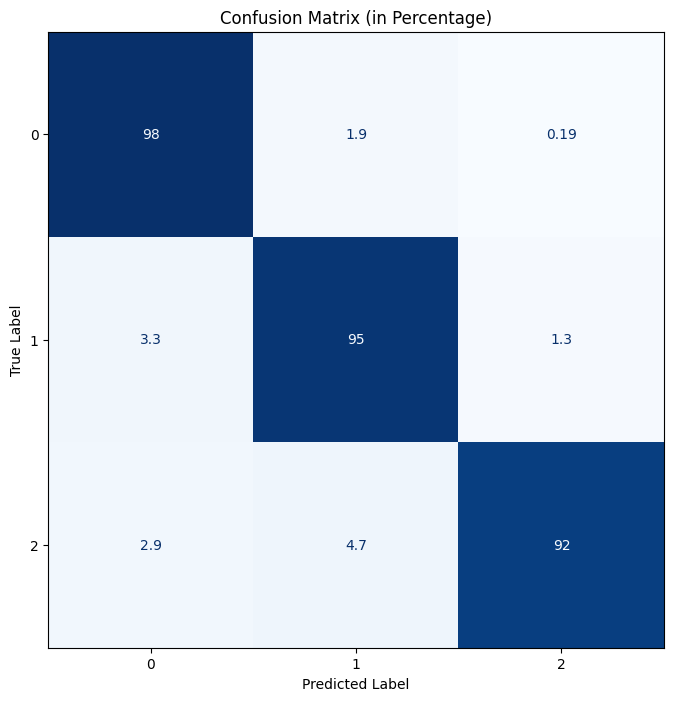

Test Accuracy: 95.26% ± 0.27%


In [18]:
with custom_object_scope({'WeightConstraint': WeightConstraint}):
    model = load_model('/global/homes/n/nrvora/Projects/Quantum/Model/qutrit_nn/tmp/100-0.3185-0.9526.h5', compile=False)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds)
accuracies = []
conf_matrices = []

for train_index, test_index in skf.split(x_test, np.argmax(y_test, axis=1)):
    x_train_fold, x_test_fold = x_test[train_index], x_test[test_index]
    y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]
    
    Y_pred_fold = model.predict(x_test_fold)
    Y_test_labels_fold = np.argmax(y_test_fold, axis=1)
    Y_pred_labels_fold = np.argmax(Y_pred_fold, axis=1)
    
    accuracy = accuracy_score(Y_test_labels_fold, Y_pred_labels_fold)
    accuracies.append(accuracy)
    
    conf_matrix_fold = confusion_matrix(Y_test_labels_fold, Y_pred_labels_fold)
    conf_matrices.append(conf_matrix_fold)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Calculate the mean and std deviation of confusion matrices
mean_conf_matrix = np.mean(conf_matrices, axis=0)
std_conf_matrix = np.std(conf_matrices, axis=0)

# Normalize the mean confusion matrix to percentage
conf_matrix_normalized = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the mean confusion matrix with error bars
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=np.arange(3))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

plt.title('Confusion Matrix (in Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(3), labels=np.arange(3))
plt.yticks(np.arange(3), labels=np.arange(3))
plt.show()

# Print the mean accuracy with error bars
print(f'Test Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')

In [21]:
std_conf_matrix,mean_conf_matrix

(array([[2.57681975, 3.37045991, 1.46969385],
        [2.48193473, 5.30659966, 4.07921561],
        [3.81575681, 2.87054002, 3.18747549]]),
 array([[937.4,  18.2,   1.8],
        [ 31.8, 922.2,  12.4],
        [ 27.8,  44.6, 883.8]]))

450/450 [==============================] - 0s 542us/step


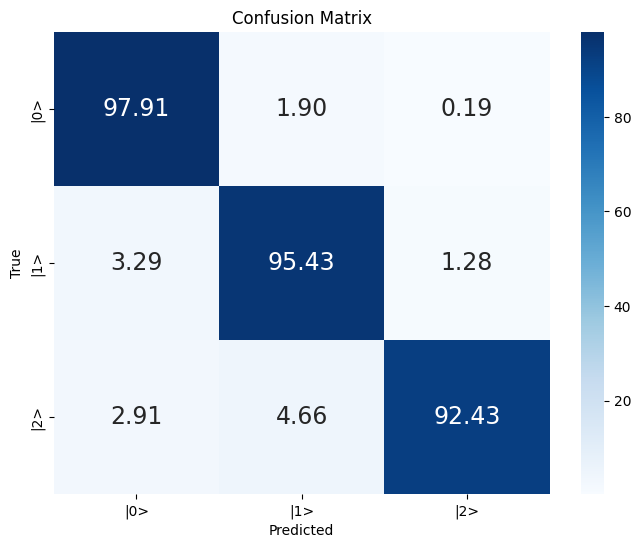

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred=model.predict(x_test)
argmax_indices = np.argmax(y_pred, axis=1)
num_classes = y_pred.shape[1]
y_pred = np.zeros_like(y_pred)
y_pred[np.arange(len(argmax_indices)), argmax_indices] = 1

# Combine the true and predicted labels into one matrix for confusion matrix computation
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Normalize the confusion matrix to show percentages
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with larger font size for percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['|0>', '|1>', '|2>'], yticklabels=['|0>', '|1>', '|2>'], annot_kws={"size": 17})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Weights and Bias extraction

In [ ]:
# model=load_model('..//Model/NN2/Best/96.6_Q3.h5', compile=False)
all_weights = model.get_weights()

# Print the shape of each layer's weights and biases
for i, weights in enumerate(all_weights):
    print(f"Layer {i} weights shape:", weights)

In [ ]:
all_weights = model.get_weights()
w,b=[],[]
for k,i in enumerate(all_weights):
    if k%2==0:
        for j in i:
            for l in j:
                w.append(l)
    else:
        for j in i:
            b.append(j)
print("Weights : ",w)
print("Bias : ",b)

In [ ]:
x=np.array([0.75291,0.34974]).reshape(1,2)
# x=x_test[4].reshape(1,2)
w0=np.array(w[:16]).reshape(2,8)
b0=np.array(b[:8]).reshape(1,8)
hidd1=np.dot(x,w0)+b0
print(hidd1)
relu1 = np.array([[x if x > 0 else 0 for x in hidd1[0]]])
print(relu1)
w1=np.array(w[16:]).reshape(8,3)
b1=np.array(b[8:]).reshape(1,3)
hidd2=np.dot(relu1,w1)+b1
print(hidd2)
print(np.exp(hidd2-hidd2[0].max()))
softmax=np.exp(hidd2-hidd2[0].max())/(np.exp(hidd2-hidd2[0].max()).sum())
print(softmax)

In [ ]:
def convert27(x):
    integer,fraction=(divmod(x, 1))
    acc_frac=int(fraction*(2**17))
    fraction_binary=str(bin(acc_frac & 0xFFFFF)[2:].zfill(17))
    if (int(integer)>=0):
        integer_binary=str(bin(int(integer) & 0xFFF)[2:].zfill(10))
    else:
        integer_binary=str(bin(int(integer) & 0b1111111111)[2:].zfill(10))
    binary_value = integer_binary+fraction_binary 
    integer_value = binary_to_integer(binary_value)
    return integer_value
    
def binary_to_integer(binary_string):
    decimal_value = int(binary_string, 2)
    return decimal_value

def convert18(x):
    integer,fraction=(divmod(x, 1))
    acc_frac=int(fraction*(2**12))
    fraction_binary=str(bin(acc_frac & 0xFFFF)[2:].zfill(12))
    if (int(integer)>=0):
        integer_binary=str(bin(int(integer) & 0xFF)[2:].zfill(6))
    else:
        integer_binary=str(bin(int(integer) & 0b111111)[2:].zfill(6))
    binary_value = integer_binary+fraction_binary 
    integer_value = binary_to_integer(binary_value)
    return integer_value

w_bin,b_bin=[],[]
for i in w:
    w_bin.append(convert18(i))
for i in b:
    b_bin.append(convert27(i))

print("Weights : ",w_bin)
print("Bias : ",b_bin)

In [12]:
import numpy as np
a=np.array([[1,2,3]]).reshape(3,1)
b=np.array([[1,2,3,4,5,6,7,8]]).reshape(8,1)
print(a @ b.T)

[[ 1  2  3  4  5  6  7  8]
 [ 2  4  6  8 10 12 14 16]
 [ 3  6  9 12 15 18 21 24]]
